In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from pretty_print_sklearn_tree import pretty_print_sklearn_tree
import matplotlib.pyplot as plt

# Load all data from train/valid/test

In [2]:
data_path = 'data_product_reviews/'
x_train_df = pd.read_csv(data_path +'x_train.csv')
y_train_df = pd.read_csv(data_path + 'y_train.csv')
x_test_df = pd.read_csv(data_path +'x_test.csv')
y_test_df = pd.read_csv(data_path +'y_test.csv')
x_val_df = pd.read_csv(data_path +'x_valid.csv')
y_val_df = pd.read_csv(data_path +'y_valid.csv')

x_train = x_train_df.values
y_train = y_train_df.values.ravel()
x_test = x_test_df.values
y_test = y_test_df.values.ravel()
x_val = x_val_df.values
y_val = y_val_df.values.ravel()

vocab_list = list(x_train_df.columns)

In [3]:
train_indices = np.arange(x_train.shape[0])
valid_indices = np.arange(x_train.shape[0], x_train.shape[0] + x_val.shape[0])
my_splitter = [(train_indices, valid_indices)]
x_tr_NF = np.vstack((x_train, x_val))
y_tr_N = np.hstack((y_train, y_val))

# Problem : Decision Trees for Review Classification

## Train a simple tree with depth 3

In [4]:
simple_tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=101
)

### **Fit the tree** 

**TODO Train on the training set** in the next coding cell

In [5]:
simple_tree.fit(x_tr_NF, y_tr_N)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,101
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### **Figure 1: Print Tree** 

Use a helper function from the starter code

In [6]:
print("Simple Decision Tree (max_depth=3):")
pretty_print_sklearn_tree(simple_tree, feature_names=vocab_list)

Simple Decision Tree (max_depth=3):
The binary tree structure has 15 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    0 are leaves
- depth   3 has    8 nodes, of which    8 are leaves
The decision tree:  (Note: Y = 'yes' to above question; N = 'no')
Decision: X['great'] <= 0.50?
  Y Decision: X['excel'] <= 0.50?
    Y Decision: X['waste'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.422 (1 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.028 (1 total training examples)
    N Decision: X['disappoint'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.885 (1 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.375 (1 total training examples)
  N Decision: X['return'] <= 0.50?
    Y Decision: X['bad'] <= 0.50?
      Y Leaf: p(y=1 | this leaf) = 0.746 (1 total training examples)
      N Leaf: p(y=1 | this leaf) = 0.412 (1 total training examples)
    N Decision: X['mov

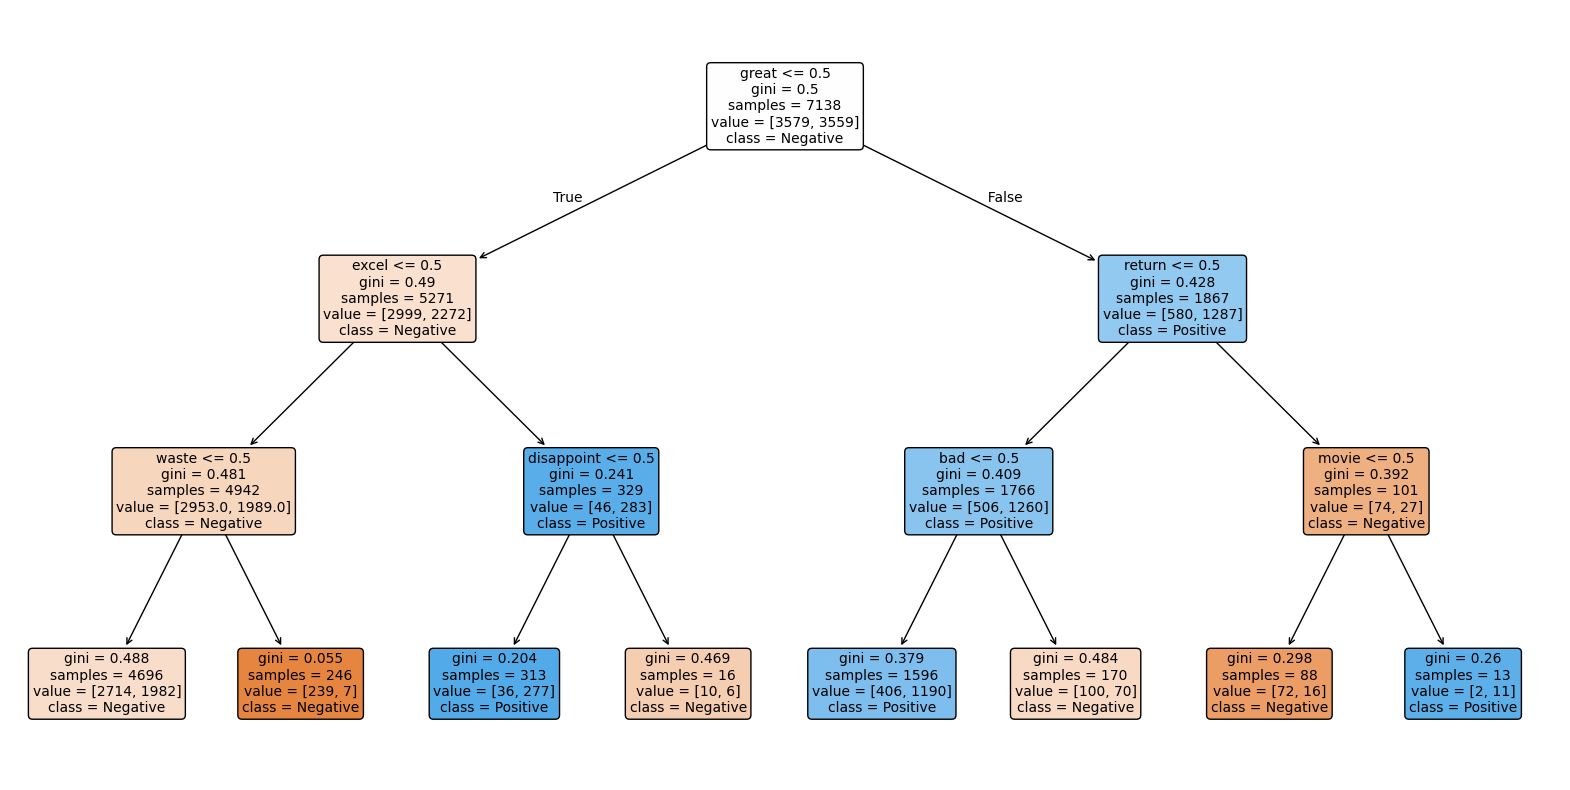

In [7]:
plt.figure(figsize=(20, 10)) 
plot_tree(
    decision_tree=simple_tree,
    feature_names=vocab_list,
    class_names=['Negative', 'Positive'], 
    filled=True,              
    rounded=True,             
    fontsize=10               
)
plt.show()

1. Is there any internal node that has two child leaf nodes corresponding to the same sentiment class? 
    - Yes, The internal node that asks Decision: X['waste'] <= 0.50?. 
    - Both of its children are leaf nodes that predict the negative sentiment class (class 0):
        - Yes (waste <= 0.50): Leads to a leaf where p(y=1) = 0.422, which predicts class 0.
        - No (waste > 0.50): Leads to a leaf where p(y=1) = 0.028, which also predicts class 0.

2. Why would having two children predict the same class make sense?
    - It makes sense because the goal of a split is to reduce impurity, not necessarily to change the final class prediction.
    - A split is considered useful if the resulting child nodes are "purer" (more homogeneous) than the parent node was. The split on the word "waste" successfully isolates a group of reviews that are very strongly negative (p(y=1) = 0.028). Even though both children predict the same class, the split has created a new, purer subgroup. This reduction in the overall weighted impurity (like Gini impurity) across the children makes the split beneficial.

## Find best Decision Tree with grid search

In [8]:
param_grid = {
    'max_depth': [2, 8, 32, 128],
    'min_samples_leaf': [1, 3, 9],
    'random_state': [101] 
}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='gini'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=my_splitter,
    return_train_score=True,
    refit=False 
)

In [9]:
grid_search.fit(x_tr_NF, y_tr_N)
results_df = pd.DataFrame(grid_search.cv_results_)
print("Grid Search Results:")
sorted_results = results_df[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'mean_train_score']].sort_values('mean_test_score', ascending=False)
print(sorted_results.to_string(index=False))

Grid Search Results:
 param_max_depth  param_min_samples_leaf  mean_test_score  mean_train_score
              32                       3         0.732380          0.877218
             128                       1         0.730313          0.996216
              32                       1         0.727378          0.918197
             128                       9         0.723193          0.832337
             128                       3         0.716495          0.924198
              32                       9         0.713458          0.814975
               8                       1         0.698887          0.726505
               8                       3         0.697599          0.721935
               8                       9         0.696208          0.712791
               2                       9         0.633931          0.640429
               2                       1         0.633931          0.640429
               2                       3         0.633931          

### Build the best decision tree

**TODO Build the Best Tree on the training set** in the next coding cell



In [10]:
base_tree = grid_search.estimator
best_params_ = grid_search.best_params_
# best_tree = base_tree # TODO call set_params using the best_params_ found by your searcher
best_tree = base_tree.set_params(**best_params_)
best_tree.fit(x_tr_NF, y_tr_N)


,criterion,'gini'
,splitter,'best'
,max_depth,32
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,101
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Interpret the best decision tree

In [11]:
pretty_print_sklearn_tree(best_tree, feature_names=vocab_list)

The binary tree structure has 853 nodes.
- depth   0 has    1 nodes, of which    0 are leaves
- depth   1 has    2 nodes, of which    0 are leaves
- depth   2 has    4 nodes, of which    0 are leaves
- depth   3 has    8 nodes, of which    0 are leaves
- depth   4 has   16 nodes, of which    5 are leaves
- depth   5 has   22 nodes, of which    8 are leaves
- depth   6 has   28 nodes, of which   14 are leaves
- depth   7 has   28 nodes, of which   12 are leaves
- depth   8 has   32 nodes, of which   13 are leaves
- depth   9 has   38 nodes, of which   17 are leaves
- depth  10 has   42 nodes, of which   21 are leaves
- depth  11 has   42 nodes, of which   19 are leaves
- depth  12 has   46 nodes, of which   24 are leaves
- depth  13 has   44 nodes, of which   22 are leaves
- depth  14 has   44 nodes, of which   22 are leaves
- depth  15 has   44 nodes, of which   25 are leaves
- depth  16 has   38 nodes, of which   20 are leaves
- depth  17 has   36 nodes, of which   17 are leaves
- dep

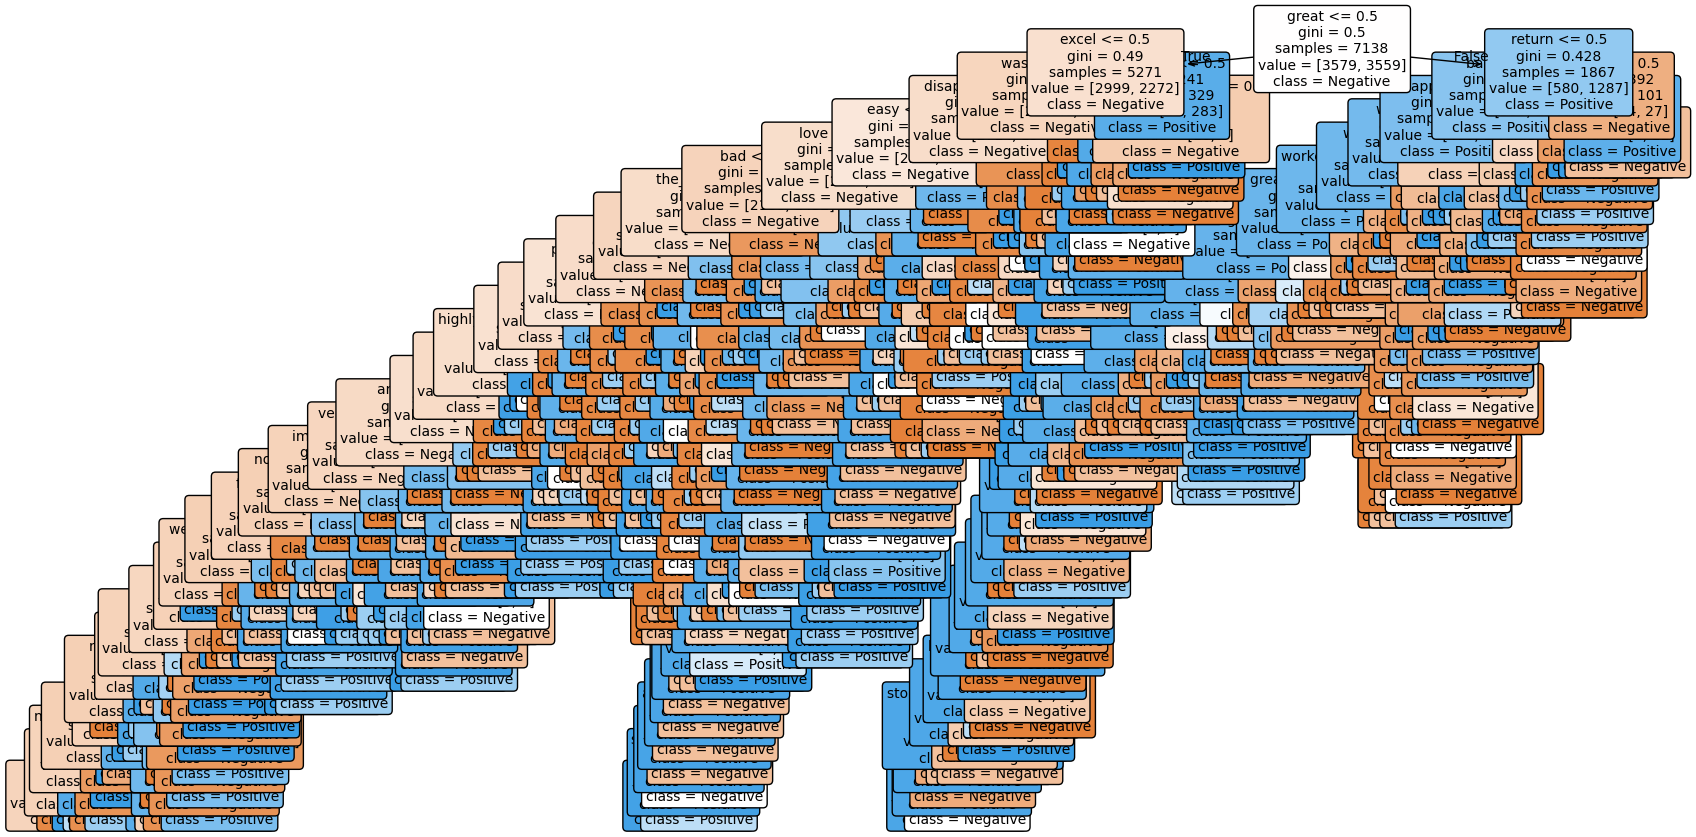

In [12]:
plt.figure(figsize=(20, 10)) 
plot_tree(
    decision_tree=best_tree,
    feature_names=vocab_list,
    class_names=['Negative', 'Positive'], 
    filled=True,              
    rounded=True,             
    fontsize=10               
)
plt.show()

1. What are the values of max depth and min samples leaf for the best tree found by the grid search?
    - Max Depth: 32
    - Min Samples Leaf: 3

# Random forest for Review Classification

## Train a random forest with default settings


In [13]:
simple_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_features='sqrt',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=101)

### Fit the forest

**TODO Train on the training set** in the next coding cell

In [14]:
simple_forest.fit(x_tr_NF, y_tr_N)

,n_estimators,100
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Feature Importances

In [15]:
importances = simple_forest.feature_importances_
feature_importance_df = pd.DataFrame({
    'word': vocab_list,
    'importance': importances
})

top_10_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
top_10_features.reset_index(drop=True, inplace=True) 

near_zero_mask = feature_importance_df['importance'] < 0.00001
near_zero_features = feature_importance_df[near_zero_mask]
num_near_zero = len(near_zero_features)

random_10_near_zero = near_zero_features.sample(10, random_state=101)
random_10_near_zero.reset_index(drop=True, inplace=True) 

comparison_table = pd.concat([
    top_10_features.rename(columns={'word': 'Top 10 Important Words', 'importance': 'Importance'}),
    random_10_near_zero.rename(columns={'word': '10 Random Near-Zero Words', 'importance': 'Importance '}) # Note space in name
], axis=1)

print("\nFeature Importance Analysis:")
print(comparison_table.to_string(index=False))
print(f"Found {num_near_zero} words with near-zero importance (< 0.00001).")


Feature Importance Analysis:
Top 10 Important Words  Importance 10 Random Near-Zero Words  Importance 
                return    0.033478                   keep_it          0.0
                 excel    0.030085                  making_a          0.0
                 worst    0.029669                  but_what          0.0
                 great    0.026954                     orang          0.0
                  poor    0.026942              thousands_of          0.0
            disappoint    0.022763                 the_image          0.0
                i_love    0.019639                  the_food          0.0
            your_money    0.018009                     users          0.0
                 don't    0.017732                lacking_in          0.0
              the_best    0.017100                   seen_in          0.0
Found 7289 words with near-zero importance (< 0.00001).


## Best Random Forest via grid search



This block might take 2-10 minutes. 

If yours runs significantly longer, try this out on Google Colab instead.

In [16]:
rf_param_grid = {
    'max_features': [3, 10, 33, 100, 333],
    'max_depth': [16, 32],
    'min_samples_leaf': [1],     
    'n_estimators': [100],      
    'random_state': [101]         
}
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_param_grid,
    scoring='balanced_accuracy',
    cv=my_splitter,
    return_train_score=True,
    refit=False,
    n_jobs=-1
)

### Do the search!

In [17]:
rf_grid_search.fit(x_tr_NF, y_tr_N)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [16, 32], 'max_features': [3, 10, ...], 'min_samples_leaf': [1], 'n_estimators': [100], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,False
,cv,"[(array([ 0, ...shape=(6346,)), ...)]"
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


### Display search results

In [18]:
#TODO
rf_results_df = pd.DataFrame(rf_grid_search.cv_results_)
sorted_rf_results = rf_results_df[[
    'param_max_features', 'param_max_depth', 'mean_test_score', 'mean_train_score'
]].sort_values('mean_test_score', ascending=False)

print("\nRandom Forest Grid Search Results:")
print(sorted_rf_results.to_string(index=False))


Random Forest Grid Search Results:
 param_max_features  param_max_depth  mean_test_score  mean_train_score
                 33               32         0.851204          0.964402
                 10               32         0.843626          0.970070
                 33               16         0.842439          0.923600
                 10               16         0.840997          0.925010
                100               16         0.839402          0.920745
                100               32         0.835434          0.969748
                333               32         0.812187          0.952712
                  3               32         0.796507          0.968174
                333               16         0.784194          0.871229
                  3               16         0.751761          0.908283


### Build the best random forest using the best hyperparameters found in 2B 

This is necessary so you have the specific best performing forest in your workspace.

Train *only* on training set (do not merge train and valid)


In [19]:
best_rf_params = rf_grid_search.best_params_
best_rf = RandomForestClassifier(**best_rf_params)
best_rf.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,32
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,33
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


1. What is the value of max_features of your best forest? 
    - Max Features: 33
    - Max Depth: 32

2. What is the maximum possible value for max_features for this dataset? Why is it beneficial to tune this hyperparameter? 
    - The maximum possible value for max_features is the total number of features in the dataset, which is 7,729.
    - It's beneficial to tune this hyperparameter because it directly controls the diversity and correlation between the trees in the forest.
    - If max_features is too high (close to 7,729), 
        - All trees will consider a similar set of features, making them highly correlated. This reduces the variance-reduction benefit of the ensemble, making it behave like a single, complex tree.
    - If max_features is too low, 
        - Each tree might not have access to enough predictive features, making the individual models too weak and increasing the overall bias of the forest. 
    - Tuning helps find the optimal balance where the trees are different enough to reduce error but strong enough to be effective predictors.

3. When fitting random forests, what is the primary tradeoff controlled by the n_estimators hyperparameter? Can you overfit by setting it to be too large? Why or why not?
    - The n_estimators hyperparameter controls the tradeoff between model performance and computational cost.
    <!-- - Increasing n_estimators (adding more trees) generally improves the model's accuracy and stability, as the errors from individual trees tend to average out. However, each additional tree increases the training time, prediction time, and memory usage. The performance gains diminish as more trees are added, so at a certain point, the extra computational expense is not worth the marginal improvement. -->

    - No, you generally cannot overfit a Random Forest by setting n_estimators to be too large. A Random Forest's prediction is the average of many individual decision trees. Each tree is trained on a different random sample of the data and considers a random subset of features. As you add more trees to the ensemble, the collective prediction becomes more stable, and the model's variance decreases. The errors from individual, decorrelated trees tend to cancel each other out, causing the model's performance to converge rather than overfit the training data. The primary limitation to increasing n_estimators is computational resources, not the risk of overfitting.

## Final Model Comparision

In [20]:
def get_model_scores(model, model_name):
    return {
        'Model Type': model_name,
        'Number of Trees': model.n_estimators if hasattr(model, 'n_estimators') else 1,
        'Max Depth': model.max_depth,
        'Train Balanced Accuracy': balanced_accuracy_score(y_train, model.predict(x_train)),
        'Validation Balanced Accuracy': balanced_accuracy_score(y_val, model.predict(x_val)),
        'Test Balanced Accuracy': balanced_accuracy_score(y_test, model.predict(x_test))
    }

scores = [
    get_model_scores(simple_tree, "Simple DT"),
    get_model_scores(best_tree, "Best DT"),
    get_model_scores(simple_forest, "Simple RF"),
    get_model_scores(best_rf, "Best RF")
]

comparison_df = pd.DataFrame(scores)
comparison_df = comparison_df[[
    'Model Type', 'Number of Trees', 'Max Depth',
    'Train Balanced Accuracy', 'Validation Balanced Accuracy', 'Test Balanced Accuracy'
]]
print("Final Model Comparison:")
print(comparison_df.to_string(index=False))

Final Model Comparison:
Model Type  Number of Trees  Max Depth  Train Balanced Accuracy  Validation Balanced Accuracy  Test Balanced Accuracy
 Simple DT                1          3                 0.645773                      0.644560                0.645849
   Best DT                1         32                 0.861125                      0.873443                0.728651
 Simple RF              100          3                 0.815652                      0.821820                0.784072
   Best RF              100         32                 0.964402                      0.851204                0.836933


### Hyperparameter Tuning Works: 
- The Best DT significantly outperforms the Simple DT. This shows that tuning hyperparameters like max_depth and min_samples_leaf is crucial for preventing overfitting and improving generalization to the validation and test sets. The Simple DT with a small depth underfits the data.

### Ensembles are Powerful: 
- Both Random Forest models (Simple RF and Best RF) outperform their Decision Tree counterparts on the test set. This demonstrates the power of ensembling; by combining many diverse trees, the Random Forest achieves better predictive performance and is more robust.

### The Best Model: 
- The Best RF is the clear winner. It achieves the highest balanced accuracy on the test set, indicating that tuning the max_features hyperparameter successfully found a good balance of tree diversity and strength, leading to the best overall performance.